# Algoritmos de optimización - Seminario

Nombre y Apellidos: Jose Luis Panadero de las Heras

Url: https://github.com/luparas95/Algoritmos/blob/main/Seminario_Algoritmos.ipynb

Problema:

>2. Organizar los horarios de partidos de La Liga<br>

## Descripción del problema:

Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la audiencia.

Los horarios disponibles se conocen a priori y son los siguientes:

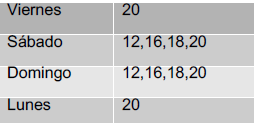

En primer lugar se clasifican los equipos en tres categorías según el numero de seguidores( que tiene relación directa con la audiencia). Hay 3 equipos en la categoría A, 11 equipos de categoría B y 6 equipos de categoría C.

Se conoce estadísticamente la audiencia que genera cada partido según los equipos que se enfrentan y en horario de sábado a las 20h (el mejor en todos los casos)

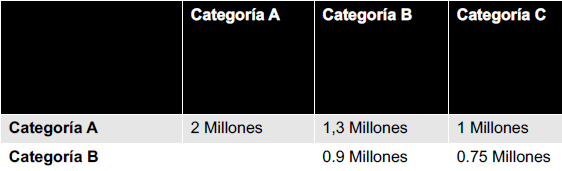

Si el horario del partido no se realiza a las 20 horas del sábado se sabe que se reduce según los coeficientes de la siguiente tabla

Debemos asignar obligatoriamente siempre un partido el viernes y un partido el lunes

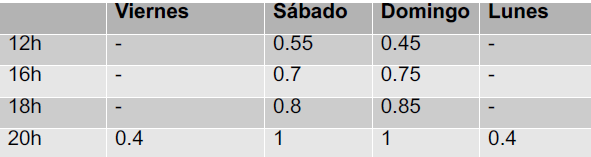

Es posible la coincidencia de horarios pero en este caso la audiencia de cada partido se verá afectada y se estima que se reduce en porcentaje según la siguiente tabla dependiendo del número de coincidencias:

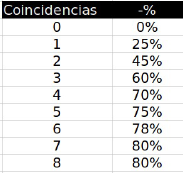

Los cálculos asociados a una jornada de ejemplo se realizan según se muestra en la siguiente tabla:

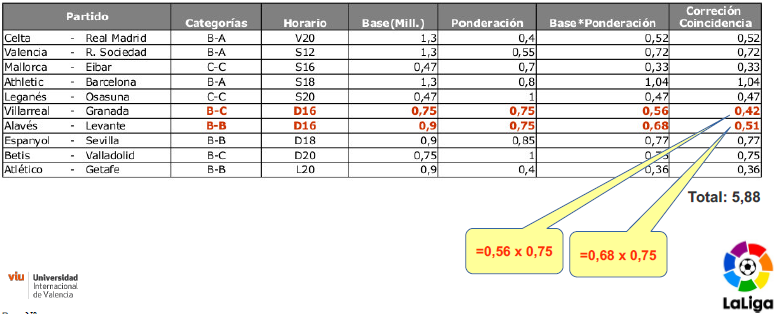

-------------------------------------------------------------------------------------------------------------------------------------

(*)¿Cuantas posibilidades hay sin tener en cuenta las restricciones?<br>



¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones.




Respuesta

**¿Cuántas posibilidades hay sin tener en cuenta las restricciones?**

Para calcular el número total de soluciones posibles es necesario aplicar principios de combinatoria. Disponemos de 10 partidos y 10 franjas horarias, por lo que se trata de un problema de permutación simple. Es decir, estamos buscando cuántas formas hay de asignar los 10 partidos a los 10 horarios distintos. Como ningún horario se repite (en este caso sin restricciones), el total de asignaciones posibles es:

$$10! = 3.628.800$$

**¿Cuántas posibilidades hay teniendo en cuenta todas las restricciones?**

Ahora debemos tener en cuenta que hay dos franjas fijas:
- 1 partido debe jugarse el viernes a las 20h
- 1 partido debe jugarse el lunes a las 20h

Por lo tanto, debemos elegir 2 partidos específicos de los 10 para ocupar estas dos franjas. Esto puede hacerse de:

$$\binom{10}{2} = \frac{10!}{2!(10-2)!} = 45 \text{ formas}$$

Una vez fijados esos 2 partidos, quedan 8 partidos para las 8 franjas restantes. Es decir, tenemos que permutar los 8 partidos restantes en 8 franjas:

$$8! = 40.320$$

Por tanto, el número total de asignaciones cumpliendo las restricciones es:

$$\binom{10}{2} × 8! = 45 × 40.320 = 1.814.400$$

-------------------------------------------------------------------------------------------------------------------------------------

Modelo para el espacio de soluciones<br>
(*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumentalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguentalo)


Respuesta

La estructura de datos que mejor se adapta a este problema es una **lista (array) de tamaño 10**, donde cada posición representa una franja horaria y el contenido de cada posición representa el partido asignado a esa franja.

Una lista ofrece eficiencia, claridad y flexibilidad, lo que la convierte en la estructura de datos más adecuada para modelar este problema.

-------------------------------------------------------------------------------------------------------------------------------------

Según el modelo para el espacio de soluciones<br>
(*)¿Cual es la función objetivo?

(*)¿Es un problema de maximización o minimización?

Respuesta

La función objetivo es **maximizar la audiencia total de la jornada**, teniendo en cuenta:

- La audiencia base estimada para cada partido según las categorías de los equipos.
- Un coeficiente de reducción por el horario asignado.
- Un coeficiente adicional por número de coincidencias en la franja horaria.

Formalmente:
$$\text{audiencia\_total} = \sum (\text{audiencia\_base} \times \text{coef\_horario} \times \text{coef\_coincidencias})$$

Es un problema de **maximización**, ya que el objetivo es lograr la **mayor audiencia posible** en el conjunto de partidos de una jornada, optimizando la asignación de horarios para cada partido.

-------------------------------------------------------------------------------------------------------------------------------------

Diseña un algoritmo para resolver el problema por fuerza bruta

Respuesta

In [1]:
# --- Cálculo de audiencia para una asignación ---
def calcular_audiencia(asignacion):
    franja_equipos = {}
    total_audiencia = 0

    for partido, horario in zip(partidos, asignacion):
        e1, e2 = partido
        c1, c2 = categoria(e1), categoria(e2)
        base = audiencia_base.get((c1, c2)) or audiencia_base.get((c2, c1))
        horario_coef = coef_horario[horario]

        if horario not in franja_equipos:
            franja_equipos[horario] = []
        franja_equipos[horario].extend([e1, e2])

        total_audiencia += base * horario_coef

    # Ajuste por coincidencias
    for jugadores in franja_equipos.values():
        coincidencias = len(jugadores) // 2  # nº de partidos en la franja
        penalizacion = coef_coincidencia[coincidencias]
        total_audiencia *= penalizacion

    return total_audiencia

# --- Fuerza bruta ---
def fuerza_bruta():
    max_audiencia = 0
    mejor_asignacion = None

    for perm in itertools.permutations(horarios):
        if perm[0] != 'Viernes 20' or perm[-1] != 'Lunes 20':
            continue  # se obliga un partido viernes y otro lunes

        audiencia = calcular_audiencia(perm)
        if audiencia > max_audiencia:
            max_audiencia = audiencia
            mejor_asignacion = perm

    return mejor_asignacion, max_audiencia

-------------------------------------------------------------------------------------------------------------------------------------

Calcula la complejidad del algoritmo por fuerza bruta

Respuesta

La complejidad del algoritmo es:
$$O(n!)$$
donde n es el número de horarios disponibles, es decir, el algoritmo tiene una complejidad factorial.

-------------------------------------------------------------------------------------------------------------------------------------

(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta

Respuesta

### Algorimo propuesto: Backtracking con poda

In [2]:
import itertools
# --- Función principal de optimización ---
def optimizar_horarios():
    # Preparamos los datos necesarios
    num_partidos = len(partidos)
    horarios_disponibles = horarios.copy()
    
    # Fijamos los horarios obligatorios
    horario_viernes = 'Viernes 20'
    horario_lunes = 'Lunes 20'
    
    # Eliminamos los horarios fijos de los disponibles
    horarios_disponibles.remove(horario_viernes)
    horarios_disponibles.remove(horario_lunes)
    
    # Estructuras para el backtracking
    mejor_asignacion = [None] * num_partidos
    mejor_audiencia = 0
    asignacion_actual = [None] * num_partidos
    
    # Asignamos los partidos fijos (primero y último)
    asignacion_actual[0] = horario_viernes
    asignacion_actual[-1] = horario_lunes

    # --- Función para calcular cota superior ---
    def calcular_cota(asignacion_parcial):
        # Implementación optimista de la audiencia posible
        audiencia = 0
        horarios_usados = set()
        partidos_asignados = 0
        
        # Calculamos lo ya asignado
        for i in range(num_partidos):
            if asignacion_parcial[i] is not None:
                e1, e2 = partidos[i]
                c1, c2 = categoria(e1), categoria(e2)
                base = audiencia_base.get((c1, c2)) or audiencia_base.get((c2, c1))
                horario_coef = coef_horario[asignacion_parcial[i]]
                audiencia += base * horario_coef
                horarios_usados.add(asignacion_parcial[i])
                partidos_asignados += 1
        
        # Estimación optimista para partidos no asignados
        for i in range(num_partidos):
            if asignacion_parcial[i] is None:
                e1, e2 = partidos[i]
                c1, c2 = categoria(e1), categoria(e2)
                base = audiencia_base.get((c1, c2)) or audiencia_base.get((c2, c1))
                
                # Tomamos el mejor coeficiente horario disponible
                mejor_coef = max(coef_horario[h] for h in horarios_disponibles 
                               if h not in horarios_usados)
                audiencia += base * mejor_coef
        
        # Aplicamos penalización mínima posible
        audiencia *= coef_coincidencia[1]
        
        return audiencia

    # --- Función recursiva de backtracking ---
    def backtrack(pos, horarios_usados):
        nonlocal mejor_asignacion, mejor_audiencia
        
        # Caso base: todos los partidos asignados
        if pos == num_partidos:
            audiencia = calcular_audiencia(asignacion_actual)
            if audiencia > mejor_audiencia:
                mejor_audiencia = audiencia
                mejor_asignacion = asignacion_actual.copy()
            return
        
        # Si la posición ya está asignada, pasamos a la siguiente
        if asignacion_actual[pos] is not None:
            backtrack(pos + 1, horarios_usados)
            return
        
        # Exploramos cada horario disponible
        for h in horarios_disponibles:
            if h not in horarios_usados:
                asignacion_actual[pos] = h
                horarios_usados.add(h)
                
                # Podamos si la cota es menor que la mejor audiencia
                cota = calcular_cota(asignacion_actual)
                if cota > mejor_audiencia:
                    backtrack(pos + 1, horarios_usados)
                
                # Retrocedemos (backtrack)
                asignacion_actual[pos] = None
                horarios_usados.remove(h)
    
    # --- Inicio del proceso de optimización ---
    backtrack(0, {horario_viernes, horario_lunes})
    
    return mejor_asignacion, mejor_audiencia

#### El algoritmo de backtracking con poda es exponencialmente más eficiente que la fuerza bruta porque:

- Reduce el espacio de búsqueda mediante restricciones integradas.
- Descarta ramas inútiles con cotas superiores.
- Mantiene la optimalidad mientras evita cálculos redundantes, ya que no evalua todo el espacio de busqueda.

-------------------------------------------------------------------------------------------------------------------------------------

(*)Calcula la complejidad del algoritmo

Respuesta

La complejidad del algoritmo es, en el peor de los casos:
$$O((n-2)!)$$
donde n es el número de horarios disponibles, es decir, el algoritmo tambien tiene una complejidad factorial teoricamente, pero en la practica a poda reduce el espacio de búsqueda en órdenes de magnitud, lo que permite ejecutar el algoritmo con un n mayor.

-------------------------------------------------------------------------------------------------------------------------------------

Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios

Respuesta

In [3]:
import random
from itertools import combinations

# --- Configuración base ---
random.seed(42)

# --- Generación de equipos ---
equipos_A = [f"A{i}" for i in range(1, random.randint(3, 5))]  # 3-4 equipos A
equipos_B = [f"B{i}" for i in range(1, random.randint(10, 13))]  # 10-12 equipos B
equipos_C = [f"C{i}" for i in range(1, random.randint(5, 8))]  # 5-7 equipos C

# --- Generación de partidos ---
def generar_partidos():
    partidos = []
    
    # 1. Partidos entre equipos de misma categoría (2 AA, 3 BB, 2 CC)
    partidos.extend(random.sample(list(combinations(equipos_A, 2)), 2))
    partidos.extend(random.sample(list(combinations(equipos_B, 2)), 3))
    partidos.extend(random.sample(list(combinations(equipos_C, 2)), 2))
    
    # 2. Partidos entre categorías diferentes (1 AB, 1 AC, 1 BC)
    partidos.append((random.choice(equipos_A), random.choice(equipos_B)))
    partidos.append((random.choice(equipos_A), random.choice(equipos_C)))
    partidos.append((random.choice(equipos_B), random.choice(equipos_C)))
    
    random.shuffle(partidos)
    return partidos[:10]

partidos = generar_partidos()

# --- Horarios ---
horarios = [
    'Viernes 20',
    *[f'Sábado {h}' for h in ['12', '16', '18', '20']],
    *[f'Domingo {h}' for h in ['12', '16', '18', '20']],
    'Lunes 20'
]

# --- Coeficientes de audiencia ---
def variar(valor):
    return round(valor * random.uniform(0.8, 1.2), 2)

audiencia_base = {
    ('A', 'A'): variar(2.0),
    ('A', 'B'): variar(1.3),
    ('A', 'C'): variar(1.0),
    ('B', 'B'): variar(0.9),
    ('B', 'C'): variar(0.75),
    ('C', 'C'): variar(0.6)
}

# --- Coeficientes horarios ---
coef_base = {
    'Viernes 20': 0.4,
    'Sábado 12': 0.55, 'Sábado 16': 0.7, 'Sábado 18': 0.8, 'Sábado 20': 1.0,
    'Domingo 12': 0.45, 'Domingo 16': 0.75, 'Domingo 18': 0.85, 'Domingo 20': 1.0,
    'Lunes 20': 0.4
}

coef_horario = {h: variar(v) for h, v in coef_base.items()}

# --- Penalización por coincidencias ---
coef_coincidencia = {
    1: 1.0, 2: 0.9, 3: 0.75, 4: 0.6, 5: 0.45,
    6: 0.3, 7: 0.2, 8: 0.1, 9: 0.05, 10: 0.01
}

# --- Función para categorizar equipos ---
def categoria(equipo):
    if equipo in equipos_A: return 'A'
    elif equipo in equipos_B: return 'B'
    else: return 'C'

# --- Restricción: partidos fijos Viernes y Lunes ---
partidos[0] = (random.choice(equipos_A + equipos_B), random.choice(equipos_A + equipos_B))  # Viernes
partidos[-1] = (random.choice(equipos_B + equipos_C), random.choice(equipos_B + equipos_C))  # Lunes

-------------------------------------------------------------------------------------------------------------------------------------

Aplica el algoritmo al juego de datos generado

Respuesta

In [4]:
# --- Ejecución FUERZA BRUTA ---
mejor_asignacion, max_audiencia = fuerza_bruta()

print("=== ASIGNACIÓN ÓPTIMA FUERZA BRUTA ===")
print(f"Audiencia total estimada: {max_audiencia:.2f} millones\n")

print("Partidos ordenados por horario:")
for partido, horario in sorted(zip(partidos, mejor_asignacion), key=lambda x: horarios.index(x[1])):
    cat_local = categoria(partido[0])
    cat_visit = categoria(partido[1])
    audiencia = audiencia_base.get((cat_local, cat_visit)) or audiencia_base.get((cat_visit, cat_local))
    impacto = audiencia * coef_horario[horario]
    print(f"{horario}: {partido[0]} vs {partido[1]} ({cat_local}{cat_visit}) | Impacto: {impacto:.2f}")

print("\nResumen por franja horaria:")
franjas = {}
for h, p in zip(mejor_asignacion, partidos):
    if h not in franjas:
        franjas[h] = []
    franjas[h].append(f"{p[0]} vs {p[1]}")
    
for h, partidos_franja in franjas.items():
    print(f"\n{h} ({len(partidos_franja)} partidos):")
    for p in partidos_franja:
        print(f"  - {p}")

=== ASIGNACIÓN ÓPTIMA FUERZA BRUTA ===
Audiencia total estimada: 8.86 millones

Partidos ordenados por horario:
Viernes 20: B3 vs A2 (BA) | Impacto: 0.50
Sábado 12: C3 vs C4 (CC) | Impacto: 0.36
Sábado 16: A1 vs C1 (AC) | Impacto: 0.52
Sábado 18: B2 vs C2 (BC) | Impacto: 0.54
Sábado 20: A1 vs B7 (AB) | Impacto: 1.23
Domingo 12: C1 vs C2 (CC) | Impacto: 0.29
Domingo 16: B2 vs B3 (BB) | Impacto: 0.79
Domingo 18: A3 vs A4 (AA) | Impacto: 1.97
Domingo 20: A1 vs A4 (AA) | Impacto: 2.26
Lunes 20: B9 vs B5 (BB) | Impacto: 0.41

Resumen por franja horaria:

Viernes 20 (1 partidos):
  - B3 vs A2

Sábado 12 (1 partidos):
  - C3 vs C4

Sábado 20 (1 partidos):
  - A1 vs B7

Sábado 18 (1 partidos):
  - B2 vs C2

Domingo 12 (1 partidos):
  - C1 vs C2

Domingo 20 (1 partidos):
  - A1 vs A4

Domingo 16 (1 partidos):
  - B2 vs B3

Domingo 18 (1 partidos):
  - A3 vs A4

Sábado 16 (1 partidos):
  - A1 vs C1

Lunes 20 (1 partidos):
  - B9 vs B5


In [5]:
# --- Ejecución BACKTRACKING + PODA ---
mejor_asignacion, max_audiencia = optimizar_horarios()

print("=== ASIGNACIÓN ÓPTIMA BACKTRACKING + PODA ===")
print(f"Audiencia total estimada: {max_audiencia:.2f} millones\n")

print("Partidos ordenados por horario:")
for partido, horario in sorted(zip(partidos, mejor_asignacion), key=lambda x: horarios.index(x[1])):
    cat_local = categoria(partido[0])
    cat_visit = categoria(partido[1])
    audiencia = audiencia_base.get((cat_local, cat_visit)) or audiencia_base.get((cat_visit, cat_local))
    impacto = audiencia * coef_horario[horario]
    print(f"{horario}: {partido[0]} vs {partido[1]} ({cat_local}{cat_visit}) | Impacto: {impacto:.2f}")

print("\nResumen por franja horaria:")
franjas = {}
for h, p in zip(mejor_asignacion, partidos):
    if h not in franjas:
        franjas[h] = []
    franjas[h].append(f"{p[0]} vs {p[1]}")
    
for h, partidos_franja in franjas.items():
    print(f"\n{h} ({len(partidos_franja)} partidos):")
    for p in partidos_franja:
        print(f"  - {p}")

=== ASIGNACIÓN ÓPTIMA BACKTRACKING + PODA ===
Audiencia total estimada: 8.86 millones

Partidos ordenados por horario:
Viernes 20: B3 vs A2 (BA) | Impacto: 0.50
Sábado 12: C3 vs C4 (CC) | Impacto: 0.36
Sábado 16: A1 vs C1 (AC) | Impacto: 0.52
Sábado 18: B2 vs C2 (BC) | Impacto: 0.54
Sábado 20: A1 vs B7 (AB) | Impacto: 1.23
Domingo 12: C1 vs C2 (CC) | Impacto: 0.29
Domingo 16: B2 vs B3 (BB) | Impacto: 0.79
Domingo 18: A3 vs A4 (AA) | Impacto: 1.97
Domingo 20: A1 vs A4 (AA) | Impacto: 2.26
Lunes 20: B9 vs B5 (BB) | Impacto: 0.41

Resumen por franja horaria:

Viernes 20 (1 partidos):
  - B3 vs A2

Sábado 12 (1 partidos):
  - C3 vs C4

Sábado 20 (1 partidos):
  - A1 vs B7

Sábado 18 (1 partidos):
  - B2 vs C2

Domingo 12 (1 partidos):
  - C1 vs C2

Domingo 20 (1 partidos):
  - A1 vs A4

Domingo 16 (1 partidos):
  - B2 vs B3

Domingo 18 (1 partidos):
  - A3 vs A4

Sábado 16 (1 partidos):
  - A1 vs C1

Lunes 20 (1 partidos):
  - B9 vs B5


Enumera las referencias que has utilizado(si ha sido necesario) para llevar a cabo el trabajo

Respuesta

### Referencias:
Apuntes de la asignatura.

YouTube:

- Programación ATS - "Backtracking (Vuelta Atrás) - Explicación y Ejemplo"

- Codigo Facilito - "Algoritmos Avanzados"

- HolaMundo - "Backtracking: Qué es y cómo implementarlo"

- WilliamFiset - "Backtracking + Pruning: The 8 Queens Problem"

- CS Dojo - "Recursion + Backtracking Explained"

Documentación oficial de Python para la librería itertools y estructuras de datos.

Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño

Respuesta

El problema puede escalar verticalmente (más partidos/horarios) y horizontalmente (nuevas restricciones/objetivos. En estos casos habría que plantear el uso de métodos heurísticos como algoritmos genéticos o colonia de hormigas.